In [ ]:
"""
1. Math of a Residual Block

Suppose input is x.
A residual block does:

y = F(x;W) + x

where:

F(x;W) = output of stacked conv layers (learnable residual function).

x = input (identity shortcut).

Forward pass (example: BasicBlock with 2 convs):
F(x;W) = sigma(BN(W2 * sigma(BN(W1 * x))))

W1, W2 are conv kernels.

BN = BatchNorm.

sigma = ReLU.

* = convolution.

Final output:

y = F(x;W) + x
2. Why This Helps Gradients

During backprop, gradient wrt input x:

dL/dx = dL/dy * (dF/dx + I)

Notice the "+ I" from the skip connection.

If dF/dx is very small (vanishing), we still have the identity path -> gradient flows easily.

That's why ResNets can be 100+ layers deep without vanishing gradient.

3. Dimensions in Skip Connections

If input and output channels differ, we can't add them directly.

Solution = 1x1 convolution shortcut to match dimensions:

x_proj = W_s * x

Then:

y = F(x;W) + x_proj
"""
print()

In [ ]:
import torch

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Basic Residual Block
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # Conv1: W1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Conv2: W2
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # if demensions change, adjust with 1x1 conv
        # Sortcut Projection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )


    def forward(self, x):
        # F(x) = two conv layers
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += self.shortcut(x)  # this is residual connection

        out = F.relu(out) # ReLU applied after adding shortcut

        return out

In [ ]:
# Tiny ResNet- like Model
class TinyResNet(nn.Module):
  def __init__(self,num_classes=10):
    super().__init__()
    self.layer1 = BasicBlock(3, 16)             # 32x32 -> 32x32
    self.layer2 = BasicBlock(16, 32,stride=2)   # 32x32 -> 16x16
    self.layer3 = BasicBlock(32, 64,stride=2)   # 16x16 -> 8x8
    self.fc = nn.Linear(64*8*8, num_classes) # this is for CIFAR-10 (32x32 input)

  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = out.view(out.size(0),-1)  # done flatten
    return self.fc(out)

In [ ]:
# testing
x = torch.randn(1,3,32,32)
model = TinyResNet()
print(model(x).shape)

torch.Size([1, 10])


In [ ]:
# training skeleton
import torch.optim as optim

model = TinyResNet(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

# example training loop (CIFAR-10)

for epoch in range(5):
  for image,labels in train_loader:
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()


Now with Full Example means DataLoader + Training

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim  as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
# --- 1. Data Preprocessing ----
# Normalize images to mean=0.5,std = 0.5, (approx range [-1,1])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [3]:
# train and test datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data',train=True,
                                             download=True,transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


In [4]:
# Data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                          shuffle=False, num_workers=2)


In [5]:
# --- 2. Residual Block (from earlier) -----
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)


In [6]:
# ---- 3.  Tiny ResNet -----
class TinyResNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.layer1 = BasicBlock(3, 16)         # 32x32 → 32x32
        self.layer2 = BasicBlock(16, 32, 2)     # 32x32 → 16x16
        self.layer3 = BasicBlock(32, 64, 2)     # 16x16 → 8x8
        self.fc = nn.Linear(64*8*8, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        return self.fc(out)

In [7]:
# --- 4. Training Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TinyResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)


In [8]:
# --- 5. Training & Evaluation ---
num_epochs = 5
train_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # --- Evaluate on test set ---
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = 100 * correct / total
    test_accuracies.append(acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Test Acc: {acc:.2f}%")


Epoch 1/5 | Loss: 2.1684 | Test Acc: 31.80%
Epoch 2/5 | Loss: 1.6716 | Test Acc: 41.65%
Epoch 3/5 | Loss: 1.4788 | Test Acc: 49.11%
Epoch 4/5 | Loss: 1.3243 | Test Acc: 47.71%
Epoch 5/5 | Loss: 1.1869 | Test Acc: 59.73%


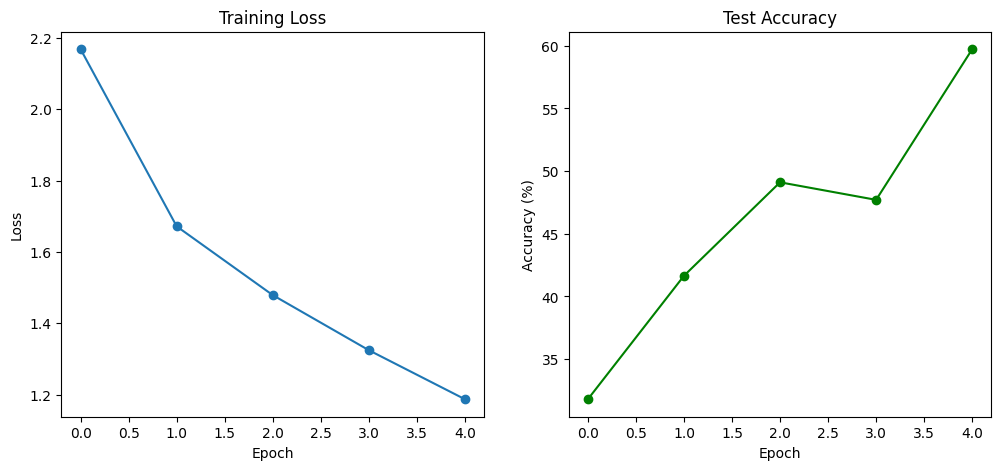

In [9]:
import matplotlib.pyplot as plt
# --- 6. Plot Curves ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(test_accuracies, marker='o', color='green')
plt.title("Test Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")

plt.show()

Plain CNN (no skip connections)

In [10]:
class TinyCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)   # 32x32 → 32x32
        self.bn1   = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)  # 32x32 → 16x16
        self.bn2   = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)  # 16x16 → 8x8
        self.bn3   = nn.BatchNorm2d(64)

        self.fc = nn.Linear(64*8*8, num_classes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.relu(self.bn3(self.conv3(out)))
        out = out.view(out.size(0), -1)
        return self.fc(out)


In [11]:
# --- 4. Training Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TinyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)


In [12]:
# --- 5. Training & Evaluation ---
num_epochs = 5
train_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # --- Evaluate on test set ---
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = 100 * correct / total
    test_accuracies.append(acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Test Acc: {acc:.2f}%")


Epoch 1/5 | Loss: 2.2312 | Test Acc: 29.04%
Epoch 2/5 | Loss: 1.8888 | Test Acc: 34.54%
Epoch 3/5 | Loss: 1.7131 | Test Acc: 35.45%
Epoch 4/5 | Loss: 1.6484 | Test Acc: 39.47%
Epoch 5/5 | Loss: 1.6164 | Test Acc: 40.31%


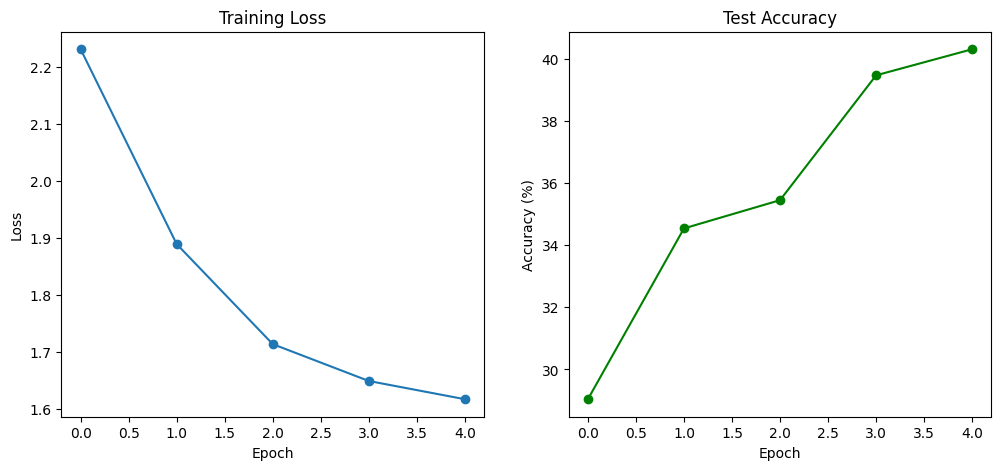

In [13]:
import matplotlib.pyplot as plt
# --- 6. Plot Curves ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(test_accuracies, marker='o', color='green')
plt.title("Test Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")

plt.show()

Scaling up TinyResNet toward ResNet-18 style

In [14]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_channels = 64

        # Stem
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # CIFAR: keep 32x32
        self.bn1   = nn.BatchNorm2d(64)

        # Stages (each halves resolution)
        self.layer1 = self._make_layer(block, 64,  num_blocks[0], stride=1)  # 32x32
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)  # 16x16
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)  # 8x8
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)  # 4x4

        # Head
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, out.size()[3])  # global avg pool
        out = out.view(out.size(0), -1)
        return self.fc(out)

# Factory function
def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes)


In [15]:
# --- 4. Training Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)


In [16]:
# --- 5. Training & Evaluation ---
num_epochs = 5
train_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # --- Evaluate on test set ---
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = 100 * correct / total
    test_accuracies.append(acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Test Acc: {acc:.2f}%")


Epoch 1/5 | Loss: 1.8500 | Test Acc: 40.28%
Epoch 2/5 | Loss: 1.3181 | Test Acc: 50.75%
Epoch 3/5 | Loss: 1.0172 | Test Acc: 62.52%
Epoch 4/5 | Loss: 0.8107 | Test Acc: 71.56%
Epoch 5/5 | Loss: 0.6518 | Test Acc: 76.03%


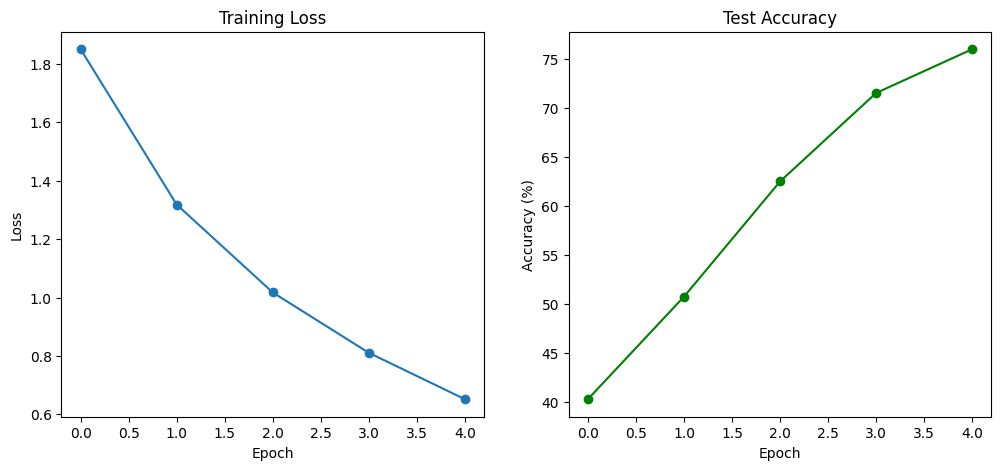

In [17]:
import matplotlib.pyplot as plt
# --- 6. Plot Curves ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(test_accuracies, marker='o', color='green')
plt.title("Test Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")

plt.show()